In [6]:
import pandas as pd
import time
from os.path import join
import json 
import numpy as np 
from tqdm import tqdm
import seaborn as sns
from os import listdir, path
import matplotlib.pyplot as plt


In [7]:

def map_failure(x):
    if pd.isna(x):
        return 0
    else:
        x  = int(x.replace('comp',''))
    return x

def map_error(x):
    if pd.isna(x):
        return 0
    else:
        x  = int(x.replace('error',''))
    return x


In [3]:
data_dir = '/workspaces/predictive_maintenance/data/raw'

listdir(data_dir)

# keep only the files that end with .parquet
files = [join(data_dir,f)  for f in listdir(data_dir) if f.endswith('.parquet')]



In [28]:
# creat a dict key is the file name and value is the path 
files_dict = {f.split('/')[-1].split('.')[0]:f for f in files}
files_dict

{'PdM_failures': '/workspaces/predictive_maintenance/data/raw/PdM_failures.parquet',
 'PdM_machines': '/workspaces/predictive_maintenance/data/raw/PdM_machines.parquet',
 'PdM_telemetry2': '/workspaces/predictive_maintenance/data/raw/PdM_telemetry2.parquet',
 'PdM_errors': '/workspaces/predictive_maintenance/data/raw/PdM_errors.parquet',
 'PdM_maint': '/workspaces/predictive_maintenance/data/raw/PdM_maint.parquet',
 'PdM_telemetry': '/workspaces/predictive_maintenance/data/raw/PdM_telemetry.parquet'}

In [29]:
# read all the files into dataframes, the name of the dataframe is df_ + the name of the file


df_PdM_errors = pd.read_parquet(files_dict['PdM_errors'])
df_PdM_maint = pd.read_parquet(files_dict['PdM_maint'])
df_PdM_telemetry = pd.read_parquet(files_dict['PdM_telemetry'])
df_PdM_failures = pd.read_parquet(files_dict['PdM_failures'])
df_PdM_machines = pd.read_parquet(files_dict['PdM_machines'])
    

In [30]:
display(df_PdM_errors.head())
display(df_PdM_maint.head())
display(df_PdM_telemetry.head())
display(df_PdM_failures.head())
display(df_PdM_machines.head())


,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [31]:
df_PdM_telemetry
# join the telemetry and failures dataframes


In [32]:
df_failures_machines = df_PdM_failures.merge(df_PdM_machines, on='machineID', how='left')

df_failures_machines['failure'] = df_failures_machines.failure.apply(map_failure)
df_failures_machines['failure_binary'] = df_failures_machines.failure.apply(lambda x: 1 if x > 0 else 0)


df_failures_telemetry = df_PdM_telemetry.merge(df_PdM_failures, on=['datetime', 'machineID'], how='left')
df_failures_telemetry['failure'] = df_failures_telemetry.failure.apply(map_failure)
df_failures_telemetry['failure_binary'] = df_failures_telemetry.failure.apply(lambda x: 1 if x > 0 else 0)

In [47]:
df_PdM_errors

# merge the errors with the df_PdM_failures 
df_failures_errors = df_PdM_errors.merge(df_PdM_failures, on=['datetime', 'machineID'], how='outer')
df_failures_errors['failure'] = df_failures_errors.failure.apply(map_failure)
df_failures_errors['failure_binary'] = df_failures_errors.failure.apply(lambda x: 1 if x > 0 else 0)
df_failures_errors.errorID = df_failures_errors.errorID.apply(map_error)



In [48]:
df_failures_telemetry.to_parquet('/workspaces/predictive_maintenance/data/interim/failures_telemetry.parquet')
df_failures_machines.to_parquet('/workspaces/predictive_maintenance/data/interim/failures_machines.parquet')
df_failures_errors.to_parquet('/workspaces/predictive_maintenance/data/interim/failures_errors.parquet')


## Analisis Bivariado 

In [8]:
df_failures_telemetry = pd.read_parquet('/workspaces/predictive_maintenance/data/interim/failures_telemetry.parquet')
df_failures_machines = pd.read_parquet('/workspaces/predictive_maintenance/data/interim/failures_machines.parquet')
df_failures_errors = pd.read_parquet('/workspaces/predictive_maintenance/data/interim/failures_errors.parquet')


In [9]:
df_failures_machines['model'] = df_failures_machines['model'].apply(lambda x: x.replace('model','')).astype(int)

In [10]:
print ('df_failures_telemetry', df_failures_telemetry.shape)
display(df_failures_telemetry.head())

print ('df_failures_machines', df_failures_machines.shape)
display(df_failures_machines.head())

print ('df_failures_errors', df_failures_errors.shape)
display(df_failures_errors.head())

df_failures_telemetry (876142, 8)


,datetime,machineID,volt,rotate,pressure,vibration,failure,failure_binary
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,0,0
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,0,0
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,0,0
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,0,0
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,0,0


df_failures_machines (761, 6)


,datetime,machineID,failure,model,age,failure_binary
0,2015-01-05 06:00:00,1,4,3,18,1
1,2015-03-06 06:00:00,1,1,3,18,1
2,2015-04-20 06:00:00,1,2,3,18,1
3,2015-06-19 06:00:00,1,4,3,18,1
4,2015-09-02 06:00:00,1,4,3,18,1


df_failures_errors (4677, 5)


,datetime,machineID,errorID,failure,failure_binary
0,2015-01-03 07:00:00,1,1,0,0
1,2015-01-03 20:00:00,1,3,0,0
2,2015-01-04 06:00:00,1,5,0,0
3,2015-01-10 15:00:00,1,4,0,0
4,2015-01-22 10:00:00,1,4,0,0


In [11]:
df_failures_telemetry.query('failure_binary == 1').head()

,datetime,machineID,volt,rotate,pressure,vibration,failure,failure_binary
96,2015-01-05 06:00:00,1,179.303153,499.777962,111.833028,52.383097,4,1
1536,2015-03-06 06:00:00,1,198.257975,456.862342,89.333995,38.671900,1,1
2616,2015-04-20 06:00:00,1,180.050801,346.362480,105.661164,39.218055,2,1
4056,2015-06-19 06:00:00,1,187.673963,493.005160,105.334392,53.963961,4,1
5856,2015-09-02 06:00:00,1,144.094532,409.380150,106.720871,57.454990,4,1


In [12]:
df_failures_telemetry.iloc[96-25:96+1].head(5)

,datetime,machineID,volt,rotate,pressure,vibration,failure,failure_binary
71,2015-01-04 05:00:00,1,170.648661,464.189726,103.742947,58.457667,0,0
72,2015-01-04 06:00:00,1,165.010140,448.468838,97.709630,48.238941,0,0
73,2015-01-04 07:00:00,1,142.666469,433.279499,118.853452,54.848731,0,0
74,2015-01-04 08:00:00,1,191.168936,479.615136,101.999663,52.882567,0,0
75,2015-01-04 09:00:00,1,157.436263,438.091311,113.100915,53.695544,0,0


In [13]:
df_failures_telemetry

,datetime,machineID,volt,rotate,pressure,vibration,failure,failure_binary
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,0,0
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,0,0
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,0,0
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,0,0
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,0,0
...,...,...,...,...,...,...,...,...
876137,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941,0,0
876138,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072,0,0
876139,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561,0,0
876140,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259,0,0


In [82]:
telemetria_fallas_30_antes = pd.DataFrame()
telemetria_sin_fallas_30 = pd.DataFrame()
tamano_ventana = 50



for i,ix in enumerate(df_failures_telemetry.query('failure_binary == 1').index):

    #df_failures_telemetry['FallaId'] = i
    df_segmento = df_failures_telemetry.iloc[ix-tamano_ventana:ix+1]  
    df_segmento['FallaId'] = i
    df_segmento['index'] = np.arange(0,tamano_ventana+1)
    telemetria_fallas_30_antes = pd.concat([telemetria_fallas_30_antes,df_segmento ])


    df_segmento = df_failures_telemetry.iloc[ix+1:ix+tamano_ventana+2]
    df_segmento['FallaId'] = 10000 + i
    df_segmento['index'] = np.arange(0,tamano_ventana+1)
    telemetria_sin_fallas_30 = pd.concat([telemetria_sin_fallas_30,df_segmento ])  

telemetria_sin_fallas_30 = telemetria_sin_fallas_30.query('failure_binary != 1')




/tmp/ipykernel_26612/2748175149.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_26612/2748175149.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_26612/2748175149.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykerne

In [83]:
telemetria_sin_fallas_30.query('FallaId <= 10005')

,datetime,machineID,volt,rotate,pressure,vibration,failure,failure_binary,FallaId,index
97,2015-01-05 07:00:00,1,155.511452,498.398435,103.068134,33.270415,0,0,10000,0
98,2015-01-05 08:00:00,1,172.439821,392.124959,108.135159,39.477497,0,0,10000,1
99,2015-01-05 09:00:00,1,138.826437,451.348967,126.464580,38.257462,0,0,10000,2
100,2015-01-05 10:00:00,1,177.278402,403.199389,100.858613,38.776021,0,0,10000,3
101,2015-01-05 11:00:00,1,180.451532,494.681408,103.810360,39.822763,0,0,10000,4
...,...,...,...,...,...,...,...,...,...,...
6983,2015-10-19 05:00:00,1,164.567853,497.630482,113.994977,30.746710,0,0,10005,46
6984,2015-10-19 06:00:00,1,187.816628,386.980239,80.943511,40.991094,0,0,10005,47
6985,2015-10-19 07:00:00,1,196.319979,479.375450,117.720014,34.639017,0,0,10005,48
6986,2015-10-19 08:00:00,1,158.369938,444.270916,88.380882,37.003301,0,0,10005,49


In [84]:
import plotly.express as px


In [85]:
fig = px.line(telemetria_fallas_30_antes.query('FallaId <= 5'), x="index", y="vibration", color='FallaId')
fig.show()





In [86]:
fig = px.line(telemetria_fallas_30_antes.query('FallaId <= 15'), x="index", y="vibration", color='FallaId')
fig.show()

In [87]:

fig = px.line(telemetria_sin_fallas_30.query('FallaId <= 15'), x="index", y="vibration", color='FallaId')
fig.show()

In [88]:
telemetria_sin_fallas_30.describe()

,machineID,volt,rotate,pressure,vibration,failure,failure_binary,FallaId,index
count,38766.000000,38766.000000,38766.000000,38766.000000,38766.000000,38766.0,38766.0,38766.000000,38766.000000
mean,51.924393,170.746629,447.770908,100.715918,40.218467,0.0,0.0,10380.073621,25.026621
std,29.494937,15.464137,51.296405,10.988173,5.221994,0.0,0.0,219.658134,14.704100
min,1.000000,106.609445,216.951250,59.867768,19.237552,0.0,0.0,10000.000000,0.000000
25%,24.000000,160.310577,414.219190,93.365205,36.761809,0.0,0.0,10190.000000,12.000000
50%,51.000000,170.534786,448.266998,100.337620,40.149418,0.0,0.0,10380.000000,25.000000
75%,79.000000,180.930517,482.333070,107.459513,43.584686,0.0,0.0,10570.000000,38.000000
max,100.000000,245.496061,683.490188,177.026941,72.335124,0.0,0.0,10760.000000,50.000000


In [89]:
df_dataset_telemetria = pd.concat([telemetria_fallas_30_antes,telemetria_sin_fallas_30])

In [90]:
datos_telemetria_agg = df_dataset_telemetria.groupby('FallaId').agg(mean_volt = ('volt', 'mean'),
                                                mean_rot = ('rotate', 'mean'),
                                                mean_press = ('pressure', 'mean'),
                                                mean_vib = ('vibration', 'mean'),
                                                max_volt = ('volt', 'max'),
                                                max_rot = ('rotate', 'max'),
                                                max_press = ('pressure', 'max'),
                                                max_vib = ('vibration', 'max'),
                                                min_volt = ('volt', 'min'),
                                                min_rot = ('rotate', 'min'),
                                                min_press = ('pressure', 'min'),
                                                min_vib = ('vibration', 'min'),
                                                std_volt = ('volt', 'std'),
                                                std_rot = ('rotate', 'std'),
                                                std_press = ('pressure', 'std'),
                                                std_vib = ('vibration', 'std'),
                                                failure_binary = ('failure_binary', 'max'),
                                                failure = ('failure', 'max')
                                                
)


In [91]:
df_dataset_telemetria

,datetime,machineID,volt,rotate,pressure,vibration,failure,failure_binary,FallaId,index
46,2015-01-03 04:00:00,1,194.942847,418.842271,95.896312,47.163648,0,0,0,0
47,2015-01-03 05:00:00,1,174.138401,489.250315,91.926306,32.323616,0,0,0,1
48,2015-01-03 06:00:00,1,177.594089,459.956670,96.651624,52.997327,0,0,0,2
49,2015-01-03 07:00:00,1,175.213280,486.494804,104.432962,47.875804,0,0,0,3
50,2015-01-03 08:00:00,1,164.341435,568.972310,94.488533,49.023585,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...
875636,2015-12-11 05:00:00,100,164.159152,478.607717,115.001156,50.269166,0,0,10760,46
875637,2015-12-11 06:00:00,100,148.737239,428.433464,74.804654,38.306979,0,0,10760,47
875638,2015-12-11 07:00:00,100,162.019465,435.515169,94.324317,38.298663,0,0,10760,48
875639,2015-12-11 08:00:00,100,173.325370,415.159379,94.719847,39.756077,0,0,10760,49


<AxesSubplot: xlabel='mean_vib', ylabel='mean_volt'>

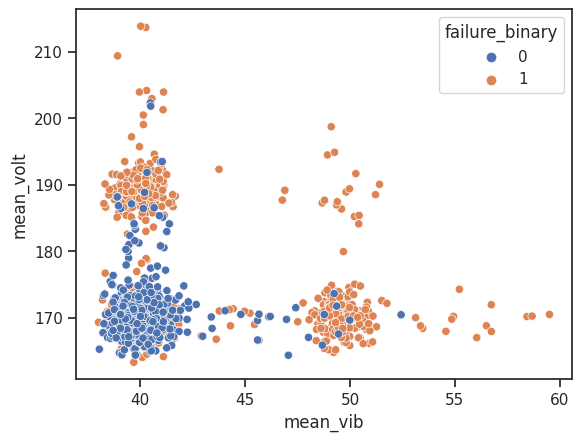

In [92]:
sns.scatterplot(data=datos_telemetria_agg, x="mean_vib", y="mean_volt", hue="failure_binary")

<AxesSubplot: xlabel='mean_vib', ylabel='mean_volt'>

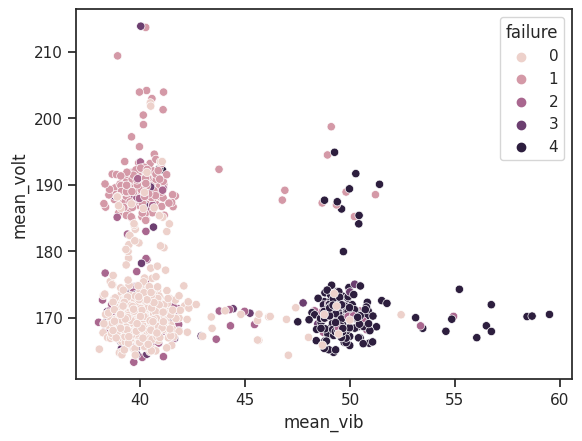

In [93]:
sns.scatterplot(data=datos_telemetria_agg, x="mean_vib", y="mean_volt", hue="failure")

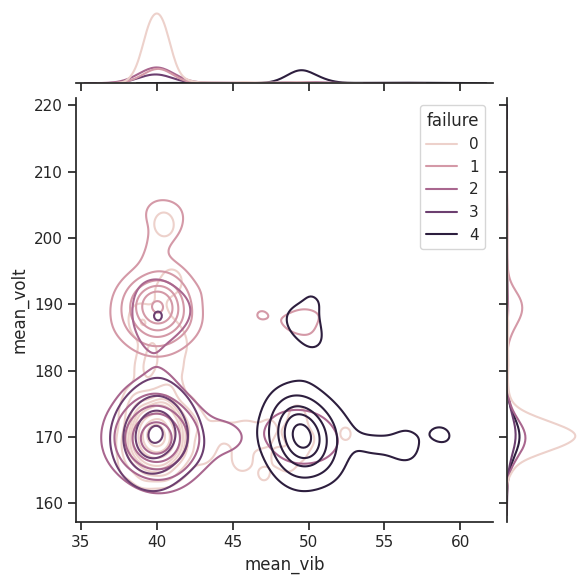

In [94]:
sns.set_theme(style="ticks")
# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=datos_telemetria_agg,
    x="mean_vib", y="mean_volt", hue="failure",
    kind="kde",
)

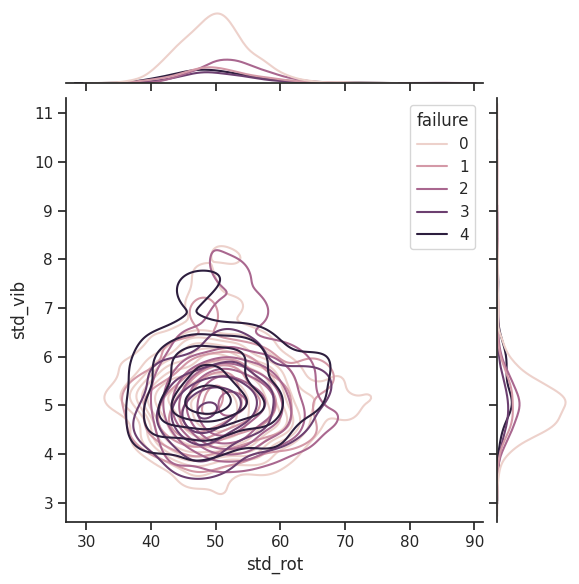

In [95]:
sns.set_theme(style="ticks")
# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=datos_telemetria_agg,
    x="std_rot", y="std_vib", hue="failure",
    kind="kde",
)

In [96]:
datos_telemetria_agg

,mean_volt,mean_rot,mean_press,mean_vib,max_volt,max_rot,max_press,max_vib,min_volt,min_rot,min_press,min_vib,std_volt,std_rot,std_press,std_vib,failure_binary,failure
FallaId,,,,,,,,,,,,,,,,,,
0,172.588081,447.468043,99.206196,51.507693,215.656488,568.972310,118.853452,66.764515,127.163620,365.213804,82.400818,32.323616,17.190119,39.994501,9.573823,6.052338,1,4
1,186.510723,447.195641,100.390042,40.145870,216.930340,549.924403,116.107596,49.029715,149.968203,354.540120,74.378060,29.981067,16.480844,48.017796,9.428387,5.177259,1,1
2,171.035700,370.242220,102.035247,39.448790,203.104007,489.502527,121.827141,50.877634,136.116842,215.619476,79.552597,30.093808,14.432076,52.912712,9.198713,4.249077,1,2
3,172.075922,465.965610,101.458377,48.742725,202.610866,590.323104,136.553131,61.150030,138.300867,387.342414,80.630055,34.449814,15.607182,45.011227,9.249428,5.733866,1,4
4,168.421840,441.550416,98.545595,53.461430,207.324122,549.741973,121.728619,67.633435,138.740244,345.711420,75.959631,39.240901,15.015761,46.885066,11.351485,7.478835,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10756,173.151346,441.088252,98.470910,39.922152,202.283046,588.845937,132.318619,48.743596,142.078755,327.843809,78.220014,25.784611,14.339157,51.240984,10.040675,5.423409,0,0
10757,171.765490,438.096576,102.766869,39.176165,203.240462,529.201978,135.545741,53.343735,136.600041,319.060936,68.514001,26.490346,15.933960,47.799873,15.455207,5.256525,0,0
10758,168.145728,439.006019,101.366865,40.502853,203.145300,518.641874,122.015017,49.274697,133.667453,350.385298,79.482624,30.528052,16.990331,42.168794,9.904275,4.206793,0,0


In [ ]:
""" sklearn.feature_selection.mutual_info_classif(X, y, *, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)[source]¶ """"

In [97]:
from sklearn.feature_selection import mutual_info_classif 

informacion_mutua_variables =  mutual_info_classif(datos_telemetria_agg.drop(columns=['failure_binary','failure']), datos_telemetria_agg['failure_binary'])

In [98]:
informacion_mutua_variables
pd.DataFrame(informacion_mutua_variables, index=datos_telemetria_agg.drop(columns=['failure_binary','failure']).columns, columns=['informacion_mutua']).sort_values(by='informacion_mutua', ascending=False)

,informacion_mutua
mean_rot,0.131502
min_rot,0.120676
mean_vib,0.105709
max_rot,0.099468
min_vib,0.084755
max_vib,0.083393
mean_volt,0.079331
max_volt,0.077248
min_press,0.073964
min_volt,0.069551


In [55]:
informacion_mutua_variables
pd.DataFrame(informacion_mutua_variables, index=datos_telemetria_agg.drop(columns=['failure_binary','failure']).columns, columns=['informacion_mutua']).sort_values(by='informacion_mutua', ascending=False)

,informacion_mutua
max_rot,0.113899
mean_rot,0.109361
min_vib,0.108919
min_rot,0.101140
mean_vib,0.082959
min_press,0.082292
min_volt,0.076567
max_volt,0.072032
max_vib,0.066076
mean_volt,0.065273


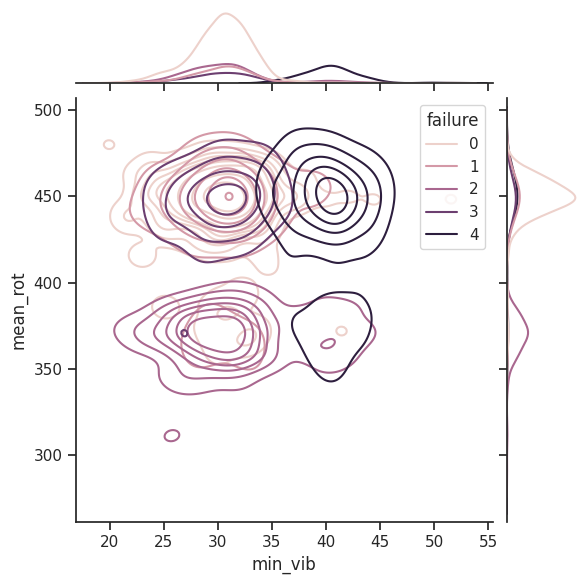

In [59]:
sns.set_theme(style="ticks")
# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=datos_telemetria_agg,
    x="min_vib", y="mean_rot", hue="failure",
    kind="kde",
)

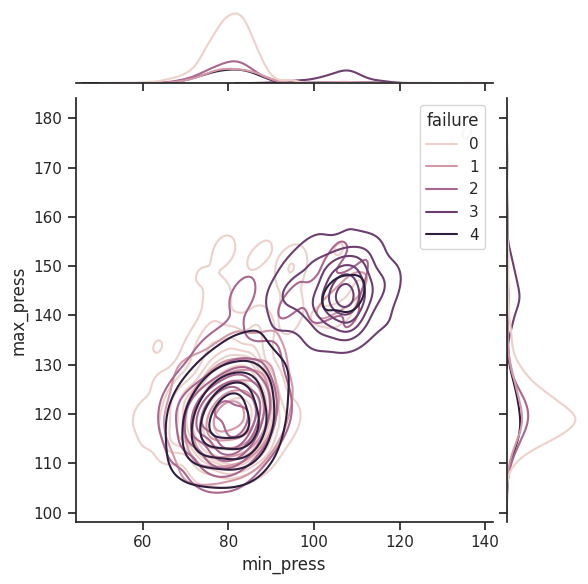

In [60]:
sns.set_theme(style="ticks")
# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=datos_telemetria_agg,
    x="min_press", y="max_press", hue="failure",
    kind="kde",
)

In [63]:
## calculo de correlaciones
corr = datos_telemetria_agg.corr()
corr.style.background_gradient(cmap='coolwarm')

,mean_volt,mean_rot,mean_press,mean_vib,max_volt,max_rot,max_press,max_vib,min_volt,min_rot,min_press,min_vib,std_volt,std_rot,std_press,std_vib,failure_binary,failure
mean_volt,1.000000,0.101820,-0.029902,-0.100814,0.770794,0.080645,-0.011621,-0.070503,0.753630,0.098583,-0.013683,-0.072679,0.056352,-0.029513,0.010885,0.027836,0.315582,-0.026441
mean_rot,0.101820,1.000000,0.037838,0.040774,0.102650,0.815777,0.057296,0.017598,0.071022,0.833157,0.036326,0.058713,0.048883,-0.064297,0.045796,-0.045356,-0.438544,-0.272773
mean_press,-0.029902,0.037838,1.000000,-0.072442,-0.016947,0.027871,0.866898,-0.080102,-0.031061,0.004779,0.858907,-0.056012,0.050032,0.023860,0.116433,-0.020713,0.283944,0.335302
mean_vib,-0.100814,0.040774,-0.072442,1.000000,-0.062146,0.021815,-0.073645,0.854402,-0.092657,0.036114,-0.050124,0.842508,0.020126,-0.003143,-0.033498,0.131394,0.338447,0.618608
max_volt,0.770794,0.102650,-0.016947,-0.062146,1.000000,0.091090,-0.004927,-0.051757,0.501516,0.095264,-0.016589,-0.046570,0.430634,-0.027302,0.026523,0.011767,0.224689,-0.024885
max_rot,0.080645,0.815777,0.027871,0.021815,0.091090,1.000000,0.049724,-0.004317,0.060409,0.610422,0.011832,0.039129,0.046326,0.320917,0.059362,-0.046683,-0.384751,-0.242797
max_press,-0.011621,0.057296,0.866898,-0.073645,-0.004927,0.049724,1.000000,-0.072264,-0.011403,0.022315,0.694811,-0.045474,0.033172,0.010925,0.424731,-0.023207,0.222888,0.262685
max_vib,-0.070503,0.017598,-0.080102,0.854402,-0.051757,-0.004317,-0.072264,1.000000,-0.063903,0.013119,-0.062961,0.673142,0.012219,-0.001978,-0.019356,0.435614,0.290038,0.511281
min_volt,0.753630,0.071022,-0.031061,-0.092657,0.501516,0.060409,-0.011403,-0.063903,1.000000,0.085989,-0.018187,-0.062428,-0.371594,-0.016370,0.015915,0.002008,0.230472,-0.035024
min_rot,0.098583,0.833157,0.004779,0.036114,0.095264,0.610422,0.022315,0.013119,0.085989,1.000000,0.001773,0.041267,0.028410,-0.399760,0.025159,-0.023611,-0.347239,-0.222385
